In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import string
import re
tf.random.set_seed(11)
from nltk.corpus import stopwords


In [156]:
stop_words = set(stopwords.words('english'))

In [157]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)


Num GPUs Available:  1


In [158]:
pd_data_train = pd.read_csv('train.csv')
pd_data_train = pd_data_train.fillna(0)
pd_data_train.drop(columns=['location','keyword'], inplace=True)
pd_data_train['text'] = pd_data_train['text'].apply(lambda text: re.sub('[^\w]', ' ',text) )

In [159]:
X = pd_data_train.drop(columns=['target','id']).to_numpy()
Y = pd_data_train['target'].to_numpy()
Y = tf.keras.utils.to_categorical(Y, 2)

In [1]:
def clean_text(text_array):
    x_preprocessed = []
    for i in range(len(text_array)):
        tokens = text_array[i:i+1][0][0].split()
        tokens = [i.lower() for i in tokens]
        # tokens = [i for i in tokens if i not in stop_words]
        tokens = [i.translate(str.maketrans('', '', string.punctuation)) for i in tokens]
        tokens = [re.sub("\s+", " ", i) for i in tokens]
        x_preprocessed.append(" ".join(tokens))

    x = np.array(x_preprocessed)
    return x


In [161]:
x = clean_text(X)

Word Embeddings


In [162]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000)
tokenizer.fit_on_texts(x)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(x)
padder = tf.keras.preprocessing.sequence.pad_sequences
padded = padder(sequences, padding='post', maxlen=20)

vocab_size = len(word_index) + 1

padded.shape
embedding_dim = 75
max_length = 20

In [163]:
x_train, x_val, y_train, y_val = train_test_split(padded,Y,test_size=0.2, random_state=23)

NN with lstm layers


In [164]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 75)            1624950   
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              71680     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 16)                2064      
                                                                 
 dense_17 (Dense)            (None, 2)                 34        
                                                                 
Total params: 1,698,728
Trainable params: 1,698,728
Non-trainable params: 0
____________________________________________

In [165]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), loss="binary_crossentropy", metrics=['accuracy'])

In [166]:
tf.debugging.disable_traceback_filtering()
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val), callbacks=EarlyStopping(monitor="val_loss",patience=2), verbose=2,)

Epoch 1/10
96/96 - 4s - loss: 0.5826 - accuracy: 0.6984 - val_loss: 0.4664 - val_accuracy: 0.7833 - 4s/epoch - 41ms/step
Epoch 2/10
96/96 - 1s - loss: 0.4016 - accuracy: 0.8314 - val_loss: 0.4505 - val_accuracy: 0.7991 - 1s/epoch - 12ms/step
Epoch 3/10
96/96 - 1s - loss: 0.3467 - accuracy: 0.8606 - val_loss: 0.4586 - val_accuracy: 0.7965 - 1s/epoch - 12ms/step
Epoch 4/10
96/96 - 1s - loss: 0.3084 - accuracy: 0.8782 - val_loss: 0.4797 - val_accuracy: 0.7892 - 1s/epoch - 12ms/step


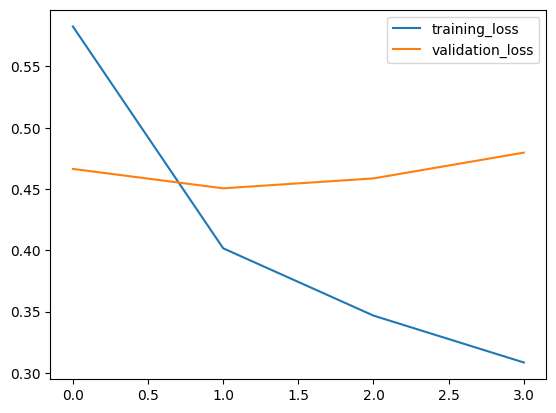

In [167]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()


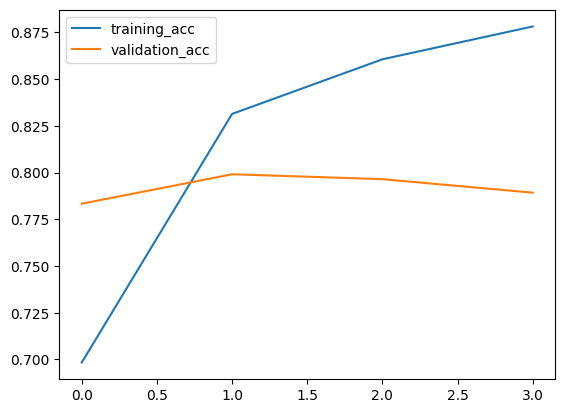

In [168]:
plt.plot(history.history['accuracy'], label='training_acc')
plt.plot(history.history['val_accuracy'], label='validation_acc')
plt.legend()


Predict on test set

In [169]:
def create_submission(model, data):
    submission = pd.DataFrame()
    submission['id'] = data[0]
    predictions = model.predict(data[1])
    submission['target'] = [i.argmax() for i in predictions]
    print(submission.head())
    return submission.to_csv('NN_submission.csv', index=False)
    

In [170]:
preds = model.predict(x_val)
errors = 0
for i in range(len(preds)):
    pred_ind = np.argmax(preds[i])
    target = np.argmax(y_val[i])
    if pred_ind != target:
        errors +=1
print(f'Total Errors: {errors}')
print(f'Accuracy: {(1 - (errors / len(preds)))*100}%')

48/48 [==============================] - 1s 4ms/step
Total Errors: 321
Accuracy: 78.92317793827971%


## Creating Submission 

In [171]:
pd_data_test = pd.read_csv('test.csv')
pd_data_test = pd_data_test.fillna(0)
pd_data_test.drop(columns=['location','keyword'], inplace=True)
pd_data_test['text'] = pd_data_test['text'].apply(lambda text: re.sub('[^\w]', ' ',text) )

In [172]:
X_test = pd_data_test.drop(columns=['id']).to_numpy()

In [173]:
test_x = clean_text(X_test)

In [174]:
tokenizer.fit_on_texts(test_x)
sequences_test = tokenizer.texts_to_sequences(test_x)
padded_test = padder(sequences_test, padding='post', maxlen=20)

In [175]:
create_submission(model, (pd_data_test['id'], padded_test))

102/102 [==============================] - 1s 5ms/step
   id  target
0   0       0
1   2       1
2   3       1
3   9       0
4  11       0
